# API and Importing Libraries

In [31]:
!pip install fredapi
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import fredapi as fa
import seaborn as sns


api_key = '4326c34340957958ddf39343ad409053'



# Testing if getting the right data

In [2]:

fred = fa.Fred(api_key=api_key)
dupage = fred.get_series('MEDLISPRI17043')
dupage.name = 'median_price'
dupage_df = dupage.to_frame()

dupage_df['county_name'] = 'Dupage County'
#extract year with index
dupage_df['year'] = dupage_df.index.year
#turn price to int
dupage_df['median_price'] = dupage_df['median_price'].astype(int)
print(dupage_df)
print(dupage_df.columns)
print(dupage_df.info())

            median_price    county_name  year
2016-07-01        395000  Dupage County  2016
2016-08-01        398500  Dupage County  2016
2016-09-01        394950  Dupage County  2016
2016-10-01        389000  Dupage County  2016
2016-11-01        387369  Dupage County  2016
...                  ...            ...   ...
2024-02-01        479610  Dupage County  2024
2024-03-01        474945  Dupage County  2024
2024-04-01        492479  Dupage County  2024
2024-05-01        525000  Dupage County  2024
2024-06-01        498900  Dupage County  2024

[96 rows x 3 columns]
Index(['median_price', 'county_name', 'year'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 2016-07-01 to 2024-06-01
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   median_price  96 non-null     int32 
 1   county_name   96 non-null     object
 2   year          96 non-null     int32 
dtypes: int32(2), object(1)
me

# Read CSV, Create List, Loop through CSV data and fetch data from FRED, Then Combine All Dataframes

In [3]:
median_price_data = pd.read_csv(r'C:/Users/kevin/Documents/analysis_docs/Illinois_Housing_Affordability/csv_files/Counties.csv')


# Create an empty list to store DataFrames
mp_dataframes = []

# Loop through county data and fetch data from FRED
for index, row in median_price_data.iterrows():
    county_name = row['county_name']
    mp_id = row['series_id']

    try:
        mp_data = fred.get_series(mp_id)
        mp_data = mp_data.to_frame(name='median_price')  # Ensure data is in a DataFrame
        mp_data['median_price'] = mp_data['median_price'].astype(int) #converts to int after fetching
        mp_data['county_name'] = county_name
        mp_data['year'] = mp_data.index.year
        mask = mp_data['year'].apply(lambda x: x < 2023) #filter data immediately
        filtered_mp_data = mp_data[mask]
        mp_dataframes.append(filtered_mp_data)
    except Exception as e:
        print(f"Error retrieving data for {county_name}: {e}")

# Combine DataFrames
combined_mp_df = pd.concat(mp_dataframes)
combined_mp_df = combined_mp_df.reset_index()
combined_mp_df.rename(columns={'index': 'Date'}, inplace=True)


print(combined_mp_df)


           Date  median_price           county_name  year
0    2016-07-01        119950      Adams County, IL  2016
1    2016-08-01        120000      Adams County, IL  2016
2    2016-09-01        120950      Adams County, IL  2016
3    2016-10-01        119000      Adams County, IL  2016
4    2016-11-01        115400      Adams County, IL  2016
...         ...           ...                   ...   ...
2569 2022-08-01        169300  Winnebago County, IL  2022
2570 2022-09-01        166825  Winnebago County, IL  2022
2571 2022-10-01        160000  Winnebago County, IL  2022
2572 2022-11-01        157475  Winnebago County, IL  2022
2573 2022-12-01        151900  Winnebago County, IL  2022

[2574 rows x 4 columns]


In [4]:
#double checking if it's int
print(combined_mp_df.dtypes)
combined_mp_df.info()

Date            datetime64[ns]
median_price             int32
county_name             object
year                     int32
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2574 entries, 0 to 2573
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          2574 non-null   datetime64[ns]
 1   median_price  2574 non-null   int32         
 2   county_name   2574 non-null   object        
 3   year          2574 non-null   int32         
dtypes: datetime64[ns](1), int32(2), object(1)
memory usage: 60.5+ KB


# Group by county

In [5]:
# Group by 'Year' and 'county_name', then calculate the mean of 'Median Price', use as_index to prevent losing column name for median price
median_price_data = combined_mp_df.copy().groupby(['year','county_name'], as_index=False)['median_price'].mean()
median_price_data['median_price'] = median_price_data['median_price'].astype(int)

print(median_price_data.iloc[100])
print(median_price_data)

year                            2019
county_name     Champaign County, IL
median_price                  190477
Name: 100, dtype: object
     year            county_name  median_price
0    2016       Adams County, IL        118383
1    2016   Champaign County, IL        150237
2    2016       Coles County, IL         85483
3    2016        Cook County, IL        271391
4    2016     De Kalb County, IL        169524
..    ...                    ...           ...
226  2022   Vermilion County, IL        101027
227  2022   Whiteside County, IL        119039
228  2022        Will County, IL        349919
229  2022  Williamson County, IL        132104
230  2022   Winnebago County, IL        145550

[231 rows x 3 columns]


# Calculate & Plot Top Median Listing Price

In [6]:
# Find the index of the minimum median price
min_index = median_price_data['median_price'].idxmin()

# Find the index of the maximum median price
max_index = median_price_data['median_price'].idxmax()

# Extract the county name from the index
min_county = median_price_data.loc[min_index, 'county_name']
max_county = median_price_data.loc[max_index, 'county_name']

print("County with minimum median price:", min_county)
print("County with maximum median price:", max_county)

County with minimum median price: Vermilion County, IL
County with maximum median price: Du Page County, IL


In [7]:
# Get top 5 counties with highest median price
top_5_max = median_price_data.groupby('county_name')['median_price'].mean().nlargest(5).astype(int)

# Get top 5 counties with lowest median price
top_5_min = median_price_data.groupby('county_name')['median_price'].mean().nsmallest(5).astype(int)

print("Top 5 counties with highest median price:\n", top_5_max)
print("Top 5 counties with lowest median price:\n", top_5_min)



Top 5 counties with highest median price:
 county_name
Du Page County, IL    406026
Lake County, IL       395922
Kane County, IL       332976
Cook County, IL       310462
Will County, IL       301388
Name: median_price, dtype: int32
Top 5 counties with lowest median price:
 county_name
Vermilion County, IL    82867
Coles County, IL        87258
Macoupin County, IL     94464
Whiteside County, IL    97478
Jackson County, IL      99952
Name: median_price, dtype: int32


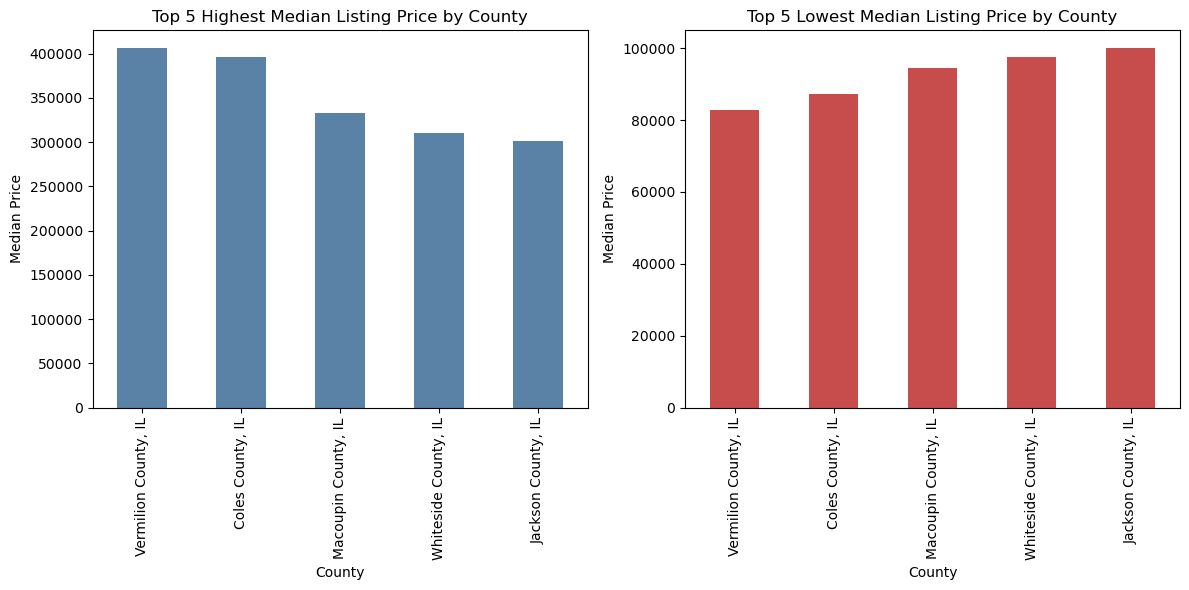

In [8]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True)

# Plot top 5 max
top_5_max.plot(kind='bar', ax=axes[0], color='#5982A6')
axes[0].set_title('Top 5 Highest Median Listing Price by County')
axes[0].set_xlabel('County')
axes[0].set_ylabel('Median Price')

# Plot top 5 min
top_5_min.plot(kind='bar', ax=axes[1], color='#C74C4C')
axes[1].set_title('Top 5 Lowest Median Listing Price by County')
axes[1].set_xlabel('County')
axes[1].set_ylabel('Median Price')

plt.tight_layout()
plt.show()

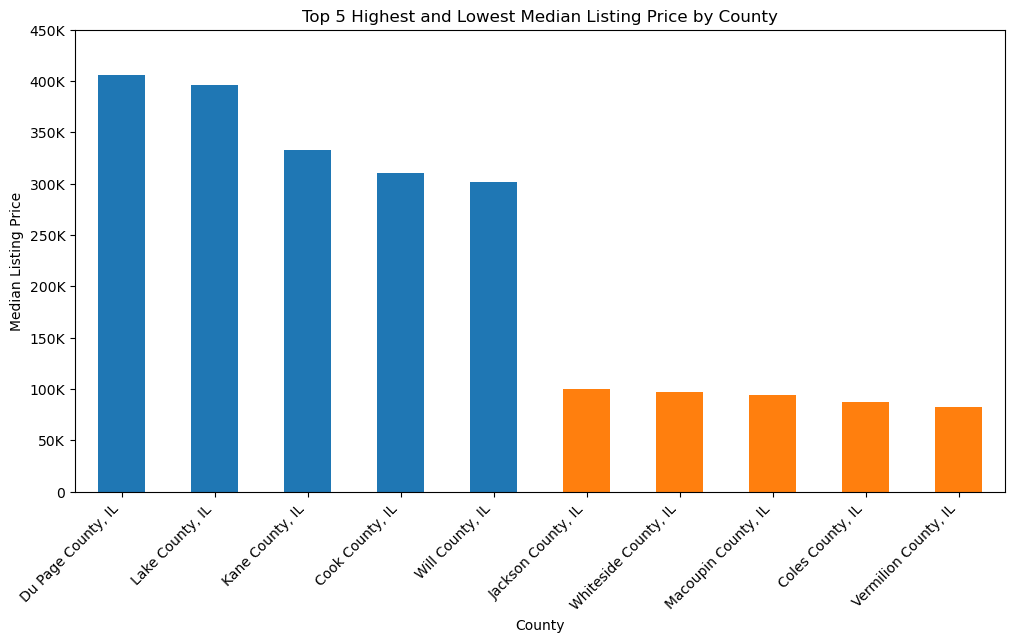

In [9]:

# Create a DataFrame with both series
combined_minmax = pd.DataFrame({'max_price': top_5_max, 'min_price': top_5_min})
#sort by columns and
combined_minmax = combined_minmax.sort_values(by=['max_price', 'min_price'], ascending=[False, False])
# Create the bar chart
combined_minmax.plot(kind='bar', stacked=True, figsize=(12, 6))



# Customize the plot
plt.title('Top 5 Highest and Lowest Median Listing Price by County')
plt.xlabel('County')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Median Listing Price')
plt.ylim(0, 450000)
plt.yticks(np.arange(0, 450001, 50000), ['0', '50K', '100K', '150K', '200K', '250K', '300K', '350K', '400K', '450K'])
plt.legend().set_visible(False)
plt.show()

In [10]:
combined_minmax.columns

Index(['max_price', 'min_price'], dtype='object')

C:\Users\kevin\AppData\Local\Temp\ipykernel_25748\3163918655.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(formatted_top_prices)


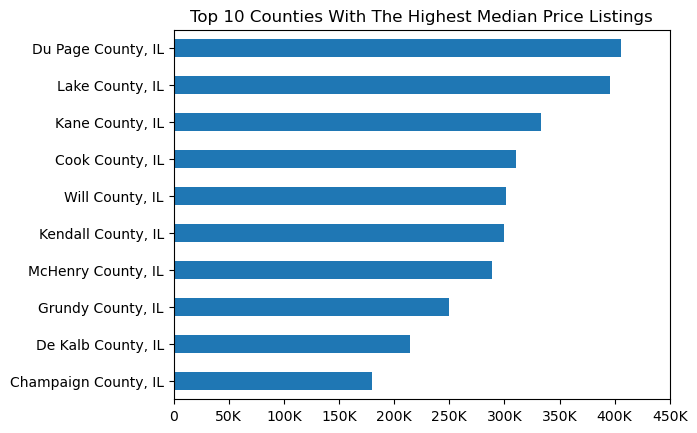

In [11]:
# Group by 'county_name', calculate mean 'Median Price', and sort in descending order
top_10_counties = median_price_data.groupby('county_name')['median_price'].mean().sort_values(ascending=False)[:10]

# Sort the top 10 counties in ascending order for correct bar orientation
top_10_counties = top_10_counties.sort_values(ascending=True)

#format prices to use on the plot
formatted_top_prices = top_10_counties.copy().apply(lambda x: f"${x/1000:.1f}K" if x >= 1000 else f"${x:.0f}")

# Create the horizontal bar chart
ax = top_10_counties.plot(kind='barh')


#set the x-axis tick labels
ax.set_xticklabels(formatted_top_prices)
plt.ylabel('')
plt.xlim(0, 450000)
plt.xticks(np.arange(0, 450001, 50000), ['0', '50K', '100K', '150K', '200K', '250K', '300K', '350K', '400K', '450K'])
plt.title('Top 10 Counties With The Highest Median Price Listings')
plt.show()



# Obtain Median Household Income

In [12]:
#get dupage median household income to test

dupage_hhincome = fred.get_series('MHIIL17043A052NCEN', start='2016-01-01')
dupage_hhincome_df = dupage_hhincome.to_frame(name='household_income')

#filter for data after 2016
dupage_hhincome_df = dupage_hhincome_df[dupage_hhincome_df.index >= pd.to_datetime('2016-01-01')]

#convert to int
dupage_hhincome_df['household_income'] = dupage_hhincome_df['household_income'].astype(int)

#add column with county name
dupage_hhincome_df['county_name'] = 'Dupage County'
dupage_hhincome_df['year'] = dupage_hhincome_df.index.year


print(dupage_hhincome_df)
print(dupage_hhincome_df.columns)
print(dupage_hhincome_df.info())

            household_income    county_name  year
2016-01-01             84999  Dupage County  2016
2017-01-01             89536  Dupage County  2017
2018-01-01             93540  Dupage County  2018
2019-01-01             96354  Dupage County  2019
2020-01-01             92101  Dupage County  2020
2021-01-01             99536  Dupage County  2021
2022-01-01            102383  Dupage County  2022
Index(['household_income', 'county_name', 'year'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7 entries, 2016-01-01 to 2022-01-01
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   household_income  7 non-null      int32 
 1   county_name       7 non-null      object
 2   year              7 non-null      int32 
dtypes: int32(2), object(1)
memory usage: 168.0+ bytes
None


# Make For Loop to aggregate all counties

In [13]:
county_data = pd.read_csv(r'C:/Users/kevin/Documents/analysis_docs/Illinois_Housing_Affordability/csv_files/Counties.csv')


# Create an empty list to store DataFrames
income_dataframes = []

# Loop through county data and fetch data from FRED
for index, row in county_data.iterrows():
    county_name = row['county_name']
    household_income = row['hh_income']

    try:
        income_data = fred.get_series(household_income, start='2016-01-01')
        income_data_df = income_data.to_frame(name='household_income')  # Ensure data is in a DataFrame
        income_data_df = income_data_df[income_data_df.index >= pd.to_datetime('2016-01-01')]

        income_data_df['household_income'] = income_data_df['household_income'].astype(int) #converts to int after fetching
        income_data_df['county_name'] = county_name
        income_data_df['year'] = income_data_df.index.year

        income_dataframes.append(income_data_df)
    except Exception as e:
        print(f"Error retrieving data for {county_name}: {e}")

# Combine DataFrames
combined_income_df = pd.concat(income_dataframes)
combined_income_df = combined_income_df.reset_index()
combined_income_df.rename(columns={'index': 'Date'}, inplace=True)


print(combined_income_df)

Error retrieving data for Effingham County, IL: Bad Request.  The series does not exist.
Error retrieving data for Peoria County, IL: Bad Request.  The series does not exist.
          Date  household_income           county_name  year
0   2016-01-01             51130      Adams County, IL  2016
1   2017-01-01             49088      Adams County, IL  2017
2   2018-01-01             55174      Adams County, IL  2018
3   2019-01-01             55942      Adams County, IL  2019
4   2020-01-01             57434      Adams County, IL  2020
..         ...               ...                   ...   ...
212 2018-01-01             53795  Winnebago County, IL  2018
213 2019-01-01             59510  Winnebago County, IL  2019
214 2020-01-01             54971  Winnebago County, IL  2020
215 2021-01-01             57113  Winnebago County, IL  2021
216 2022-01-01             62557  Winnebago County, IL  2022

[217 rows x 4 columns]


In [14]:
combined_income_df.columns

Index(['Date', 'household_income', 'county_name', 'year'], dtype='object')

# Top 10 Counties With Highest Median Household Income

In [15]:
#group by county and take mean 
income_avg = combined_income_df.copy().groupby(['county_name'], as_index=False)['household_income'].mean()
income_avg['household_income'] = income_avg['household_income'].astype(int)
income_avg = income_avg.sort_values(by='household_income', ascending=False)[:10].reset_index(drop=True)
print(income_avg)

          county_name  household_income
0  Kendall County, IL             98311
1  Du Page County, IL             94064
2     Lake County, IL             92485
3  McHenry County, IL             89292
4     Will County, IL             88841
5     Kane County, IL             83109
6   Grundy County, IL             80391
7   McLean County, IL             69219
8     Cook County, IL             67776
9     Ogle County, IL             67049


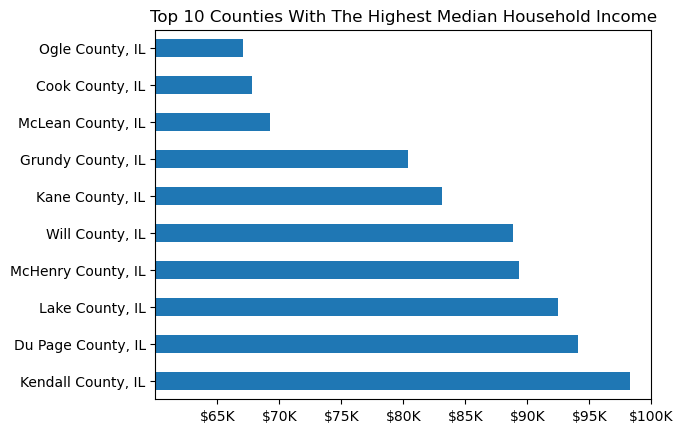

In [16]:
income_avg.plot(kind='barh', x='county_name', legend=False)
income_avg = income_avg.iloc[::-1]

# Set x-axis limits
plt.xlim(60000, 100000)
#make custom range to clean up numbers
plt.xticks(range(65000, 105000, 5000), [f"${x/1000:.0f}K" for x in range(65000, 105000, 5000)])
plt.ylabel('')
plt.title('Top 10 Counties With The Highest Median Household Income')
plt.show()


# Merging Household Income and Median Price Listings

In [17]:
#double checking both datasets for cleaning issues etc
combined_income_df.info()
median_price_data.info()
print(combined_income_df)

print(median_price_data)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              217 non-null    datetime64[ns]
 1   household_income  217 non-null    int32         
 2   county_name       217 non-null    object        
 3   year              217 non-null    int32         
dtypes: datetime64[ns](1), int32(2), object(1)
memory usage: 5.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          231 non-null    int32 
 1   county_name   231 non-null    object
 2   median_price  231 non-null    int32 
dtypes: int32(2), object(1)
memory usage: 3.7+ KB
          Date  household_income           county_name  year
0   2016-01-01             51130      Adams County, IL  2016
1   2017-01-01   

# Calculate Price / Income ratio

In [18]:
merged_data = pd.merge(median_price_data, combined_income_df, on=['year', 'county_name'], how='outer')
merged_data = merged_data.drop('Date', axis=1)
merged_data['pi_ratio'] = merged_data['median_price'] / merged_data['household_income']
merged_data.info()
print(merged_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              231 non-null    int32  
 1   county_name       231 non-null    object 
 2   median_price      231 non-null    int32  
 3   household_income  217 non-null    float64
 4   pi_ratio          217 non-null    float64
dtypes: float64(2), int32(2), object(1)
memory usage: 7.3+ KB
     year            county_name  median_price  household_income  pi_ratio
0    2016       Adams County, IL        118383           51130.0  2.315333
1    2016   Champaign County, IL        150237           51032.0  2.943976
2    2016       Coles County, IL         85483           42066.0  2.032116
3    2016        Cook County, IL        271391           60025.0  4.521299
4    2016     De Kalb County, IL        169524           59586.0  2.845031
..    ...                    ...           ...         

# Plot income to price ratio over time by color coded county


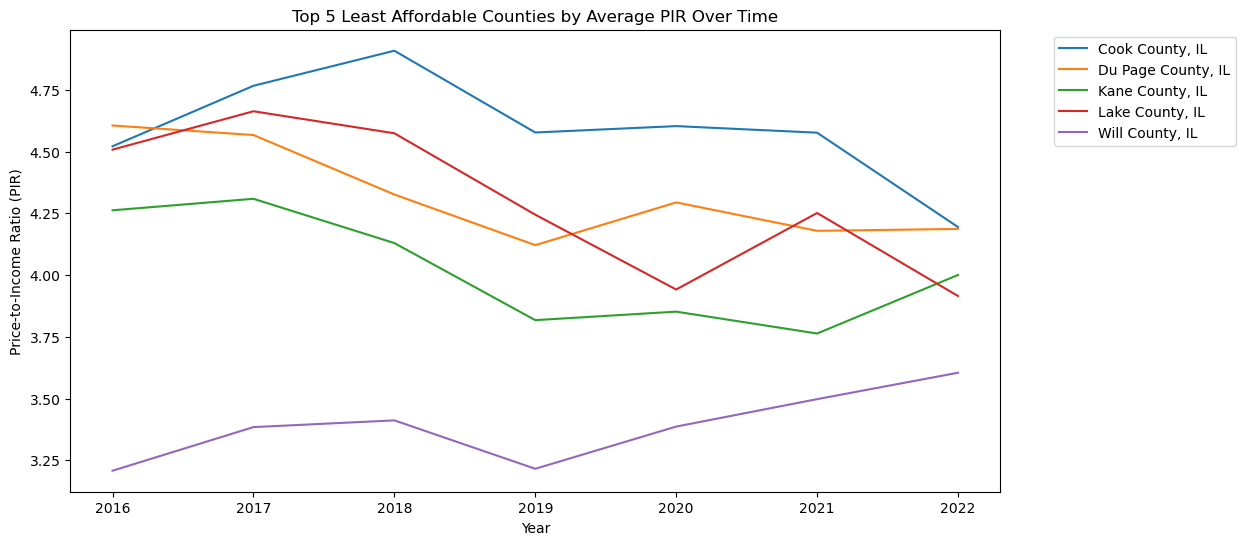

In [20]:

# Calculate average PIR per county
avg_pir = merged_data.groupby('county_name')['pi_ratio'].mean()

# Get top 5 counties by average PIR
least_affordable_counties = avg_pir.sort_values(ascending=False).head(5).index
# Filter data for top 5 counties
least_affordable_data = merged_data[merged_data['county_name'].isin(least_affordable_counties)]

# Pivot the data
pivoted_data = least_affordable_data.pivot_table(index='year', columns='county_name', values='pi_ratio')

# Create the line plot
pivoted_data.plot(figsize=(12, 6))
# Customize the plot
plt.xlabel('Year')
plt.ylabel('Price-to-Income Ratio (PIR)')
plt.title('Top 5 Least Affordable Counties by Average PIR Over Time')
# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

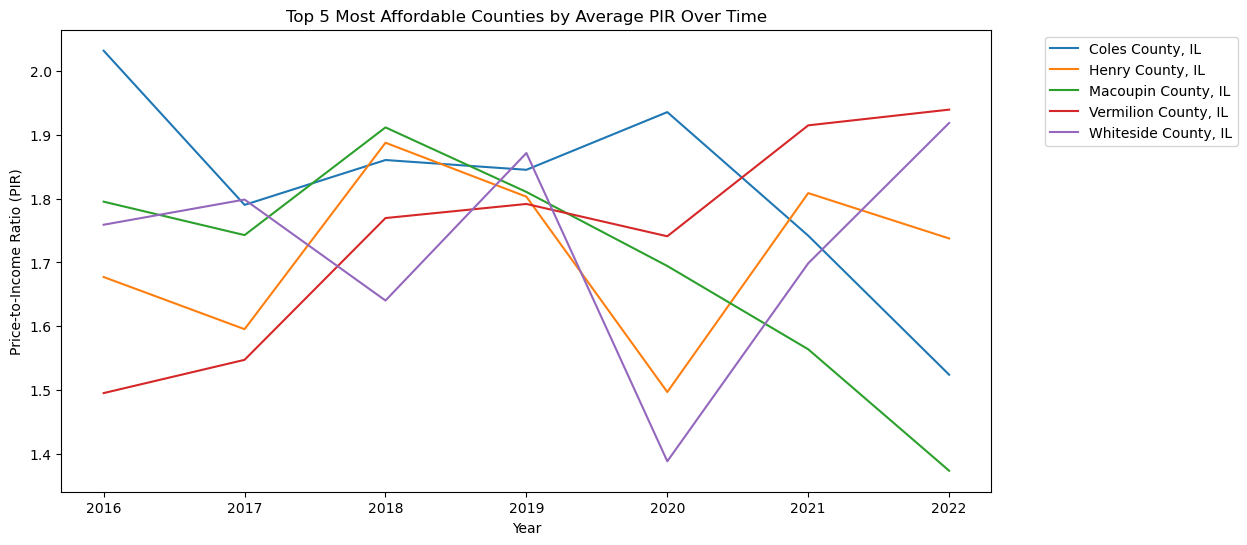

In [22]:
# Get bottom 5 counties by average PIR
most_affordable_counties = avg_pir.sort_values(ascending=True).head(5).index
# Filter data for bottom 5 counties
most_affordable_data = merged_data[merged_data['county_name'].isin(most_affordable_counties)]

# Pivot the data
pivoted_data = most_affordable_data.pivot_table(index='year', columns='county_name', values='pi_ratio')

# Create the line plot
pivoted_data.plot(figsize=(12, 6))
# Customize the plot
plt.xlabel('Year')
plt.ylabel('Price-to-Income Ratio (PIR)')
plt.title('Top 5 Most Affordable Counties by Average PIR Over Time')
# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

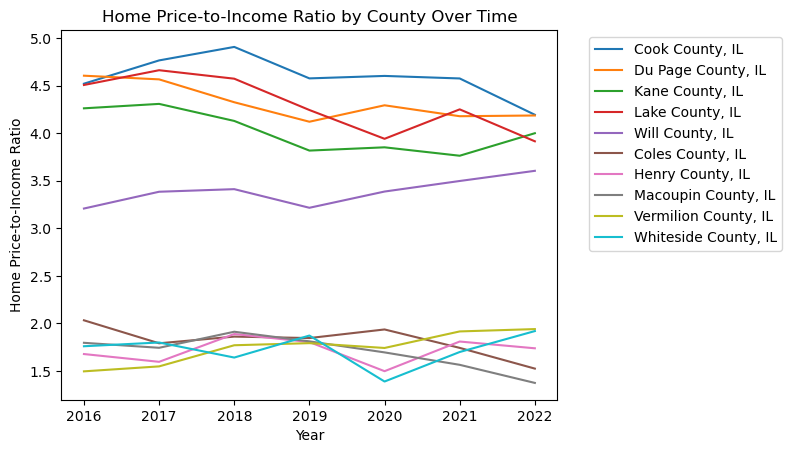

In [35]:
# Combine counties with highest and lowest average pi ratios
combined_affordability = pd.concat([least_affordable_data, most_affordable_data], ignore_index=True)

# Create the line plot
sns.lineplot(x="year", y="pi_ratio", hue="county_name", data=combined_affordability)
plt.xlabel("Year")
plt.ylabel("Home Price-to-Income Ratio")
plt.title("Home Price-to-Income Ratio by County Over Time")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Most Volatile Price to Income Ratios over the years?

county_name
Adams County, IL          0.005577
Champaign County, IL      0.012289
Coles County, IL          0.044029
Cook County, IL           0.011187
De Kalb County, IL        0.060066
Du Page County, IL        0.015242
Effingham County, IL      0.044556
Grundy County, IL         0.051882
Henry County, IL          0.014819
Jackson County, IL        0.058043
Kane County, IL           0.009541
Kankakee County, IL       0.027114
Kendall County, IL        0.051005
Knox County, IL           0.061232
La Salle County, IL       0.031280
Lake County, IL           0.021420
Macon County, IL          0.007838
Macoupin County, IL       0.041379
Madison County, IL        0.016199
McHenry County, IL        0.007630
McLean County, IL         0.073408
Ogle County, IL           0.018655
Peoria County, IL         0.035889
Rock Island County, IL    0.023875
Sangamon County, IL       0.025551
St. Clair County, IL      0.066633
Stephenson County, IL     0.013325
Tazewell County, IL       0.031551
Vermilio

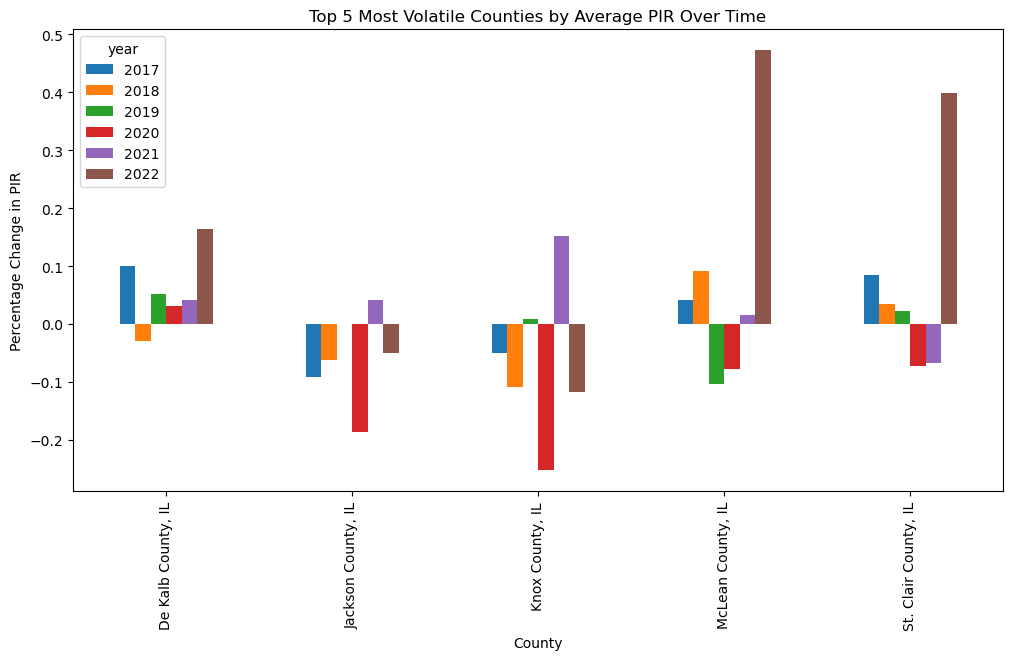

In [ ]:

# Calculate the percentage change in pi_ratio
grouped_pir_data['pi_ratio_pct_change'] = grouped_pir_data.groupby('county_name')['pi_ratio'].pct_change()

# Calculate average absolute percentage change for each county
avg_pct_change = grouped_pir_data.groupby('county_name')['pi_ratio_pct_change'].mean().abs()
print(avg_pct_change)
# Get the top 5 counties by average percentage change
top_5_apc_counties = avg_pct_change.sort_values(ascending=False).head(5).index
print(top_5_apc_counties)
# Filter data for top 5 counties
top_5_apc_data = grouped_data[grouped_data['county_name'].isin(top_5_apc_counties)]

# Pivot the data for plotting
pivoted_data = top_5_apc_data.pivot_table(index='county_name', columns='year', values='pi_ratio_pct_change')

# Create the bar chart
pivoted_data.plot(kind='bar', figsize=(12, 6))

# Customize the plot
plt.xlabel('County')
plt.ylabel('Percentage Change in PIR')
plt.title('Top 5 Most Volatile Counties by Average PIR Over Time')

plt.show()

# Examine oddity in volality within McLean County & St. Clair County

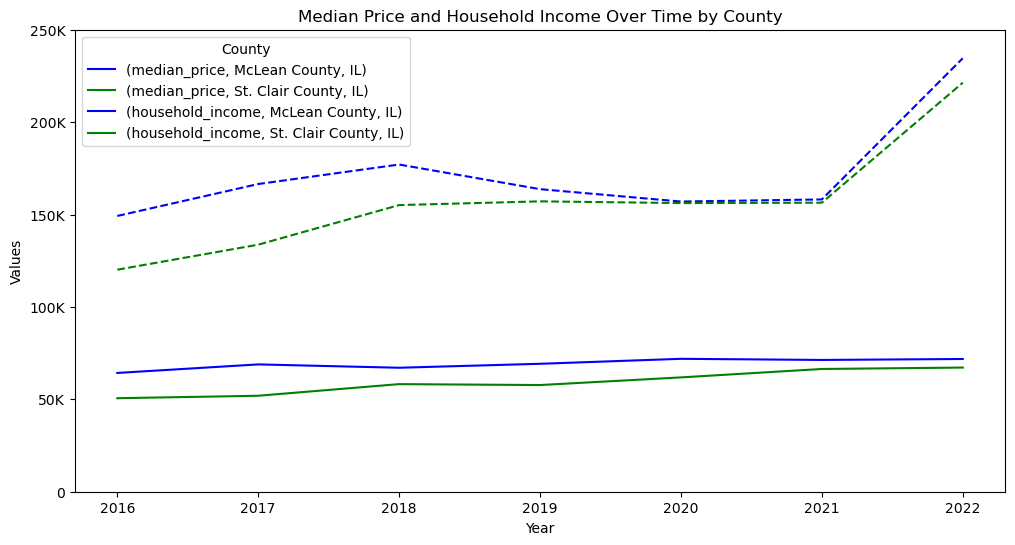

     year           county_name  median_price  household_income  pi_ratio
20   2016     McLean County, IL        149225             64271  2.321809
25   2016  St. Clair County, IL        120154             50598  2.374679
53   2017     McLean County, IL        166502             68895  2.416750
58   2017  St. Clair County, IL        133677             51937  2.573830
86   2018     McLean County, IL        177052             67087  2.639140
91   2018  St. Clair County, IL        155110             58222  2.664113
119  2019     McLean County, IL        163721             69230  2.364885
124  2019  St. Clair County, IL        157126             57726  2.721928
152  2020     McLean County, IL        157026             71919  2.183373
157  2020  St. Clair County, IL        156197             61863  2.524886
185  2021     McLean County, IL        158166             71309  2.218037
190  2021  St. Clair County, IL        156402             66422  2.354672
218  2022     McLean County, IL       

In [ ]:
# Filter for specific counties
selected_counties = merged_data[merged_data['county_name'].isin(['McLean County, IL', 'St. Clair County, IL'])]

# Group by county and year, then calculate mean values
grouped_data = selected_counties.groupby(['county_name', 'year']).mean().reset_index()

# Pivot the data for plotting
pivoted_data = grouped_data.pivot(index='year', columns='county_name', values=['median_price', 'household_income'])

# Create the line plot
ax = pivoted_data.plot(figsize=(12, 6), color=['blue', 'green'])

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Values')
plt.title('Median Price and Household Income Over Time by County')
plt.legend(title='County')
plt.ylim(0, 250000)
plt.yticks(np.arange(0, 250001, 50000), ['0', '50K', '100K', '150K', '200K', '250K'])

# Iterate through lines and set linestyle for median price
for line in ax.lines:
    if 'median_price' in line.get_label():
        line.set_linestyle('--')

plt.show()
print(merged_data[merged_data['county_name'].isin(['McLean County, IL', 'St. Clair County, IL'])])


